In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm

In [33]:

batch_size = 400

num_epochs = 50

learning_rate = 1e-4

data_set_root = "../../datasets"

gpu_indx = 0
device = torch.device(gpu_indx if torch.cuda.is_available() else 'cpu')




Create a transform for the input data

In [34]:


transform = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])



Create the training, testing and validation data

In [35]:
train_data = datasets.CIFAR10(data_set_root, train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(data_set_root, train=False, download=True, transform=test_transform)

validation_split = 0.9


n_train_examples = int(len(train_data) * validation_split)
n_valid_examples = len(train_data) - n_train_examples


train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples],
                                                       generator=torch.Generator().manual_seed(42))



Files already downloaded and verified
Files already downloaded and verified


Check the lengths of all the datasets

In [36]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


Create the dataloader

In [37]:

train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = dataloader.DataLoader(valid_data, batch_size=batch_size)
test_loader  = dataloader.DataLoader(test_data, batch_size=batch_size)

Create the CNN with Self Attention

In [38]:
class CNN(nn.Module):
    def __init__(self, channels_in):
    
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(channels_in, 64, 3, 1, 1, padding_mode='reflect')


        self.norm = nn.LayerNorm(64)
        self.mha = nn.MultiheadAttention(64, num_heads=1, batch_first=True)
        self.scale = nn.Parameter(torch.zeros(1))


        self.conv2 = nn.Conv2d(64, 64, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(128)

      
        self.do = nn.Dropout(0.5)
        self.fc_out = nn.Linear(128*4*4, 10)

    def use_attention(self, x):

        bs, c, h, w = x.shape
        x_att = x.reshape(bs, c, h * w).transpose(1, 2)  
       
        x_att = self.norm(x_att)
      
        att_out, att_map  = self.mha(x_att, x_att, x_att)
        return att_out.transpose(1, 2).reshape(bs, c, h, w), att_map

    def forward(self, x):
       
        x = self.conv1(x)

      
        x = self.scale * self.use_attention(x)[0] + x

        
        x = F.relu(x)

      
        x = F.relu(self.bn1(self.conv2(x)))
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.bn3(self.conv4(x)))

    
        x = self.do(x.reshape(x.shape[0], -1))

 
        return self.fc_out(x)


Create our model and view the ouput!

In [39]:


dataiter = next(iter(test_loader))

test_images, test_labels = dataiter

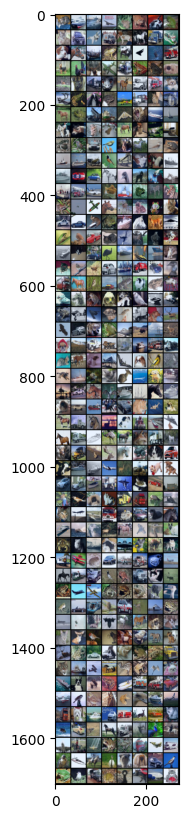

In [40]:

plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_images, 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [41]:


model = CNN(channels_in = test_images.shape[1]).to(device)

print(model)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (mha): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=2048, out_features=10, bias=True)
)


In [42]:

num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 298059 (Approximately 0 Million) Parameters!


In [43]:

out = model(test_images.to(device))

out.shape

torch.Size([400, 10])


Set up the optimizer

In [44]:

optimizer = optim.Adam(model.parameters(), lr = learning_rate)

loss_fun = nn.CrossEntropyLoss()


Define the training process

In [45]:

def train(model, optimizer, loader, device, loss_fun, loss_logger):


    model.train()
    for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Training")):
       
        fx = model(x.to(device))


        loss = loss_fun(fx, y.to(device))


        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        loss_logger.append(loss.item())

    return model, optimizer, loss_logger

In [46]:

def evaluate(model, device, loader):

    epoch_acc = 0

 
    model.eval()

    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Evaluating")):
      
            fx = model(x.to(device))

            epoch_acc += (fx.argmax(1) == y.to(device)).sum().item()


    return epoch_acc / len(loader.dataset)

In [47]:
training_loss_logger = []
validation_acc_logger = []
training_acc_logger = []
valid_acc = 0
train_acc = 0


pbar = trange(0, num_epochs, leave=False, desc="Epoch")
for epoch in pbar:
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Val %.2f%%' % (train_acc * 100, valid_acc * 100))


    model, optimizer, training_loss_logger = train(model=model,
                                                   optimizer=optimizer,
                                                   loader=train_loader,
                                                   device=device,
                                                   loss_fun=loss_fun,
                                                   loss_logger=training_loss_logger)

    train_acc = evaluate(model=model, device=device, loader=train_loader)
    valid_acc = evaluate(model=model, device=device, loader=valid_loader)

    
    validation_acc_logger.append(valid_acc)
    training_acc_logger.append(train_acc)

print("Training Complete")

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training Complete



Plot Metrics

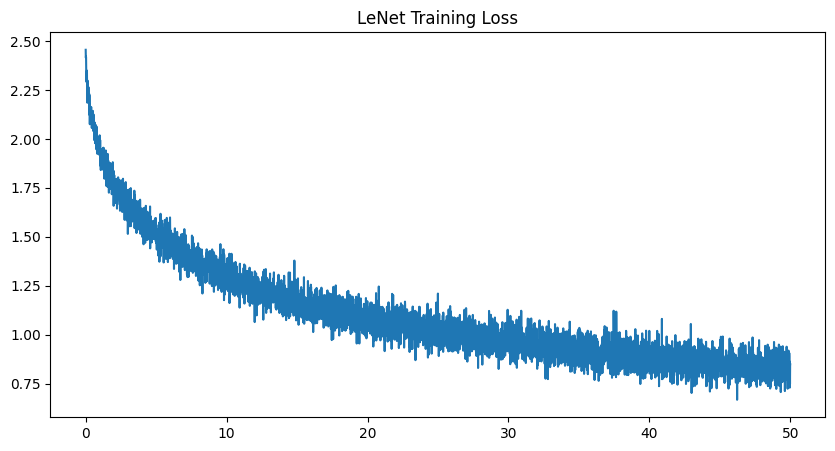

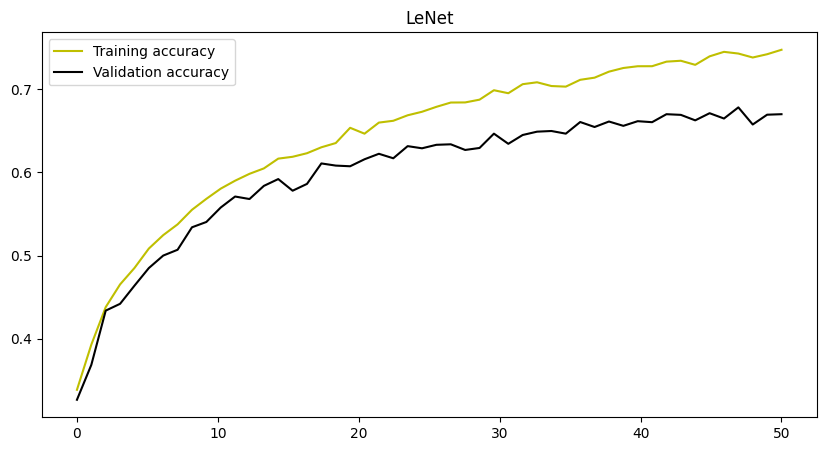

In [48]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger)
_ = plt.title("LeNet Training Loss")
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(training_acc_logger))
plt.plot(train_x, training_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(validation_acc_logger))
plt.plot(valid_x, validation_acc_logger, c = "k")

plt.title("LeNet")
_ = plt.legend(["Training accuracy", "Validation accuracy"])


Evaluate

In [49]:

test_acc = evaluate(model=model, device=device, loader=test_loader)
print("The total test accuracy is: %.2f%%" %(test_acc*100))

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

The total test accuracy is: 75.42%


Predicted Values
 [3, 1, 8, 0, 6, 6, 1, 6]
True Values
 [3, 8, 8, 0, 6, 6, 1, 6]


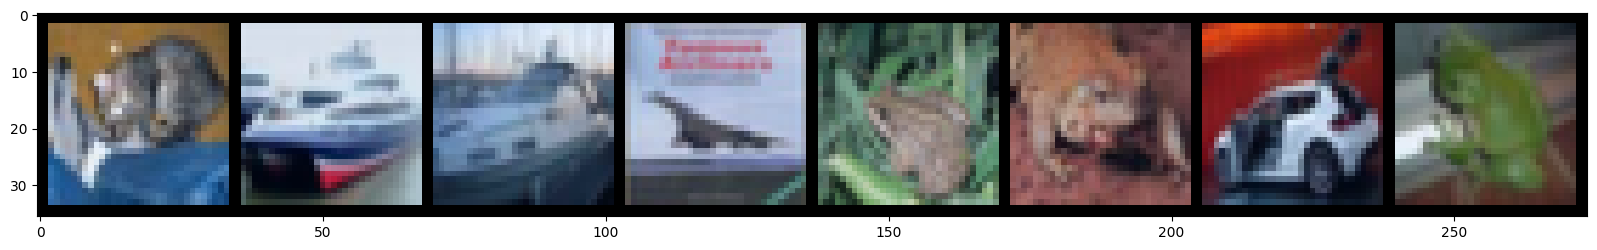

In [50]:


with torch.no_grad():
    fx = model(test_images[:8].to(device))
    pred = fx.argmax(-1)

plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_images[:8], 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

print("Predicted Values\n", list(pred.cpu().numpy()))
print("True Values\n", list(test_labels[:8].numpy()))

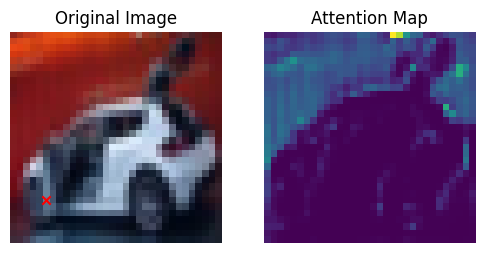

In [51]:

with torch.no_grad():
    x = model.conv1(test_images[:8].to(device))
    _, att_map = model.use_attention(x)


img_idx = 6


x_dim = 5
y_dim = 25

assert x_dim < test_images.shape[3], "x_dim must be less than " + str(test_images.shape[3] - 1)
assert y_dim < test_images.shape[2], "y_dim must be less than " + str(test_images.shape[2] - 1)


fig, axes = plt.subplots(1, 2, figsize=(6, 3))


img_out = test_images[img_idx]
img_out = (img_out - img_out.min())/(img_out.max() - img_out.min())
axes[0].imshow(img_out.permute(1, 2, 0).cpu().numpy())
axes[0].set_title("Original Image")
axes[0].axis('off')
axes[0].scatter(x_dim, y_dim, color='red', marker='x')

axes[1].imshow(att_map[img_idx, x_dim * y_dim].reshape(32, 32).cpu().numpy(), cmap='viridis')
axes[1].set_title("Attention Map")
axes[1].axis('off')

plt.show()